In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np

In [3]:
!git clone https://github.com/alexhepburn/pixel-cnn-pp pixelcnn
!unzip /content/drive/MyDrive/Colab/Archive-1f46.zip -d ./

Cloning into 'pixelcnn'...
remote: Enumerating objects: 457, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 457 (delta 29), reused 25 (delta 25), pack-reused 423
Receiving objects: 100% (457/457), 7.81 MiB | 10.08 MiB/s, done.
Resolving deltas: 100% (61/61), done.
unzip:  cannot find or open /content/drive/MyDrive/Colab/Archive-1f46.zip, /content/drive/MyDrive/Colab/Archive-1f46.zip.zip or /content/drive/MyDrive/Colab/Archive-1f46.zip.ZIP.


In [4]:
# Para descargar el modelo
# https://mega.nz/folder/W7IhST7R#PV7Pbet8Q07GxVLGnmQrZg

%load_ext autoreload
%autoreload 2
import sys
import torch
sys.path.append('/content/pixelcnn/')
from pixelcnn.model import *
from pixelcnn.utils import *

obs = (3, 32, 32)
input_channels = obs[0]

args = {}
args['nr_resnet'] = 5
args['nr_filters'] = 160
args['input_channels'] = obs[0]
args['nr_logistic_mix'] = 10

model = PixelCNN(nr_resnet=args['nr_resnet'], nr_filters=args['nr_filters'],
            input_channels=input_channels, nr_logistic_mix=args['nr_logistic_mix'])
model = model.cuda()
model = model.eval()
param_dict = torch.load('/content/drive/MyDrive/RESEARCH/Prob_vs_Perc/pixelcnn/pcnn_lr.0.00040_nr-resnet5_nr-filters160_889.pth', map_location='cpu')
param_dict = {k[7:]:v for k, v in param_dict.items()}
model.load_state_dict(param_dict)

loss_op   = lambda real, fake : discretized_mix_logistic_loss(real, fake)


def log_prob(x):
  x = x.cuda()
  y = model(x)
  return discretized_mix_logistic_loss(x, y)


def prob_grad(x):
  x = torch.tensor(x, requires_grad=True)
  prob = log_prob(x)
  grad = torch.autograd.functional.jacobian(log_prob, x)
  return prob.detach().cpu().numpy(), grad.detach().cpu().numpy()

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [5]:
batch_size = 20

from keras.datasets import cifar10
(x_train_ori, _), (x_test_ori, _) = cifar10.load_data()
x_train = x_train_ori.astype('float32')/255
x_test = x_test_ori.astype('float32')/255


170498071/170498071 [==============================] - 13s 0us/step


In [6]:
x_train = np.transpose(x_train,(0,3,1,2))
x_test = np.transpose(x_test,(0,3,1,2))
print(x_train.shape)

(50000, 3, 32, 32)


In [7]:

x_np = x_train[0:1,:,:,:]
x_np.shape

(1, 3, 32, 32)

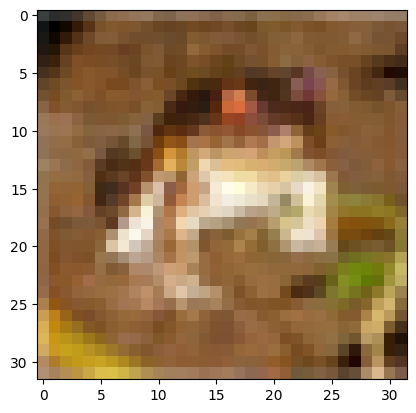

In [8]:
import matplotlib.pyplot as plt


plt.imshow(np.transpose(x_np[0],(1,2,0)))

In [9]:
# CALCULAMOS EL GRADIENTE DE LA PROBABILIDAD
GG = prob_grad(x_np)

In [10]:
#probabilidada
GG[0]

array([-6154.8276], dtype=float32)

In [11]:
MM = np.max(np.abs(np.transpose(GG[1][0,0],(1,2,0))))

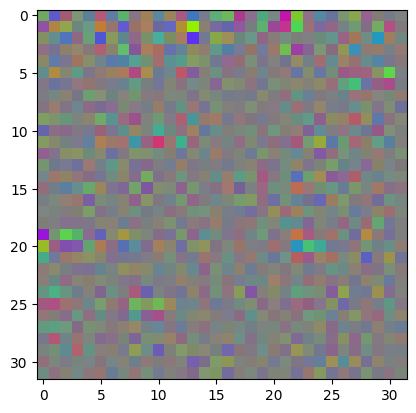

In [12]:
# Gradiente de la probabilidad respecto a la imagen
plt.imshow(0.5+np.transpose(GG[1][0,0],(1,2,0))/(2*MM))

In [19]:
x_np.min()

0.0

<ipython-input-4-e5217d2c3bfe>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, requires_grad=True)


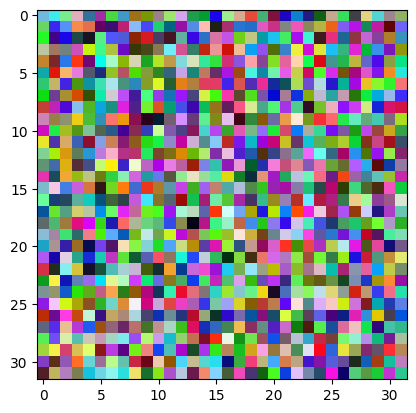

In [17]:
# CALCULAMOS EL GRADIENTE DE LA PROBABILIDAD DEL RUIDO

x_np_noise = 0.01*x_np+1*np.random.rand(3,32,32) # *
plt.imshow(np.transpose(x_np_noise[0],(1,2,0)))
GG_noise = prob_grad(torch.tensor(np.float32(x_np_noise), requires_grad=True))

In [20]:
GG_noise[0]

array([-17005.318], dtype=float32)

<ipython-input-4-e5217d2c3bfe>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, requires_grad=True)


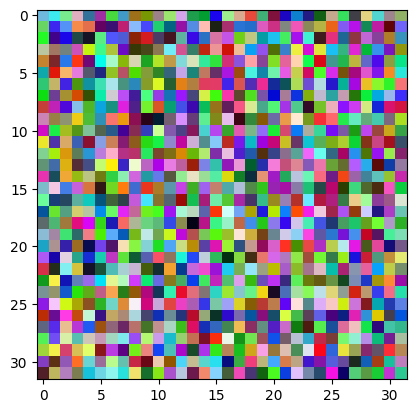

In [21]:
# Modificamos la imagen ruidosa para subirle la probabilidad

Derivada = GG[1][0]

salto = 0.0000005

X_limpiada = x_np_noise + salto*Derivada
plt.imshow(np.transpose(X_limpiada[0],(1,2,0)))
GG_limpiada = prob_grad(torch.tensor(np.float32(X_limpiada), requires_grad=True))


In [22]:
GG_limpiada[0]

array([-17005.443], dtype=float32)

<ipython-input-4-e5217d2c3bfe>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, requires_grad=True)
<ipython-input-24-e5f3fbf7d63b>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pS[n] = GG_limpiada[0]


0 [-16987.488]


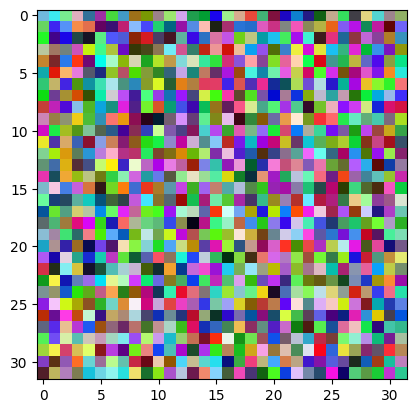

1 [-16968.996]
2 [-16946.371]
3 [-16917.832]
4 [-16903.25]
5 [-16881.723]
6 [-16860.127]
7 [-16836.066]
8 [-16815.338]
9 [-16791.814]
10 [-16768.78]
11 [-16746.285]
12 [-16728.076]
13 [-16706.348]
14 [-16684.928]
15 [-16663.79]
16 [-16640.025]
17 [-16619.305]
18 [-16598.838]
19 [-16578.623]
20 [-16558.643]
21 [-16538.863]
22 [-16521.967]
23 [-16502.541]
24 [-16483.3]
25 [-16464.266]
26 [-16445.428]
27 [-16426.799]
28 [-16408.371]
29 [-16390.164]
30 [-16372.171]
31 [-16357.408]
32 [-16339.822]
33 [-16322.43]
34 [-16305.199]
35 [-16288.115]
36 [-16271.202]
37 [-16254.435]
38 [-16233.958]
39 [-16217.448]
40 [-16201.098]
41 [-16184.939]
42 [-16168.926]
43 [-16148.455]
44 [-16132.696]
45 [-16117.001]
46 [-16101.4375]
47 [-16086.045]
48 [-16070.768]
49 [-16055.606]
50 [-16040.543]
51 [-16025.578]
52 [-16010.73]
53 [-15995.982]
54 [-15981.299]
55 [-15966.765]
56 [-15952.395]
57 [-15938.123]
58 [-15923.934]
59 [-15914.134]
60 [-15895.744]
61 [-15881.76]
62 [-15867.836]
63 [-15849.719]
64 [-158

100 [-15376.16]


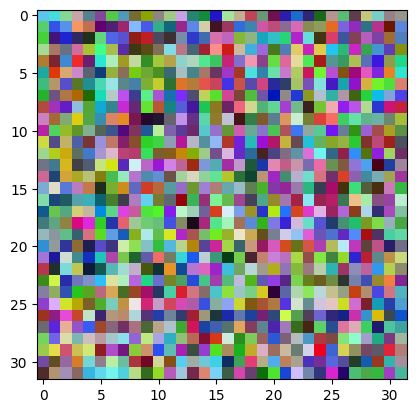

101 [-15364.086]
102 [-15351.679]
103 [-15342.559]
104 [-15326.852]
105 [-15317.677]
106 [-15302.009]
107 [-15292.773]
108 [-15277.133]
109 [-15267.808]
110 [-15252.148]
111 [-15242.814]
112 [-15230.351]
113 [-15214.846]
114 [-15205.469]
115 [-15193.003]
116 [-15180.521]
117 [-15168.021]
118 [-15155.485]
119 [-15142.93]
120 [-15130.358]
121 [-15117.762]
122 [-15105.137]
123 [-15092.494]
124 [-15079.817]
125 [-15067.093]
126 [-15054.344]
127 [-15041.629]
128 [-15028.965]
129 [-15016.311]
130 [-15003.635]
131 [-14990.926]
132 [-14978.215]
133 [-14965.527]
134 [-14952.853]
135 [-14940.18]
136 [-14927.506]
137 [-14914.839]
138 [-14902.183]
139 [-14889.552]
140 [-14876.92]
141 [-14864.295]
142 [-14851.709]
143 [-14839.153]
144 [-14826.621]
145 [-14814.113]
146 [-14801.625]
147 [-14789.146]
148 [-14776.676]
149 [-14764.198]
150 [-14751.719]
151 [-14739.232]
152 [-14726.748]
153 [-14714.238]
154 [-14701.676]
155 [-14689.082]
156 [-14676.5205]
157 [-14663.984]
158 [-14651.451]
159 [-14638.919]

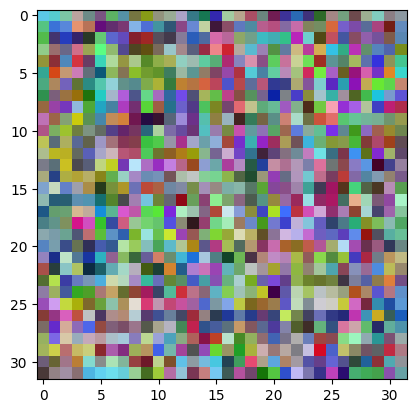

201 [-14089.927]
202 [-14075.771]
203 [-14061.608]
204 [-14047.391]
205 [-14033.111]
206 [-14018.7705]
207 [-14004.359]
208 [-13989.882]
209 [-13975.322]
210 [-13960.68]
211 [-13945.934]
212 [-13931.117]
213 [-13916.342]
214 [-13901.576]
215 [-13887.33]
216 [-13871.361]
217 [-13856.693]
218 [-13841.139]
219 [-13826.701]
220 [-13810.148]
221 [-13794.925]
222 [-13779.48]
223 [-13764.844]
224 [-13747.678]
225 [-13732.088]
226 [-13716.301]
227 [-13701.324]
228 [-13683.626]
229 [-13667.671]
230 [-13651.44]
231 [-13636.021]
232 [-13617.949]
233 [-13601.652]
234 [-13584.871]
235 [-13568.68]
236 [-13550.293]
237 [-13534.262]
238 [-13515.495]
239 [-13498.921]
240 [-13480.404]
241 [-13464.219]
242 [-13444.146]
243 [-13425.93]
244 [-13407.828]
245 [-13390.967]
246 [-13371.776]
247 [-13355.07]
248 [-13334.059]
249 [-13314.118]
250 [-13295.408]
251 [-13276.622]
252 [-13256.461]
253 [-13234.746]
254 [-13215.707]
255 [-13194.321]
256 [-13176.029]
257 [-13153.449]
258 [-13134.644]
259 [-13112.072]
260

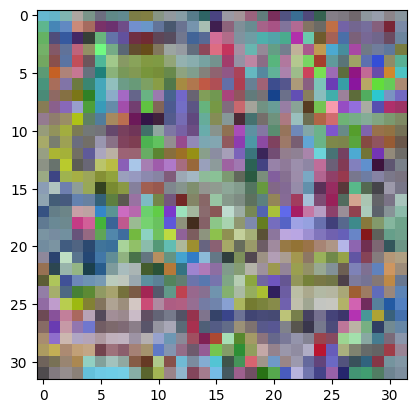

301 [-12140.971]
302 [-12135.252]
303 [-12107.113]
304 [-12078.106]
305 [-12027.737]
306 [-12043.907]
307 [-11993.871]
308 [-11982.561]
309 [-11938.146]
310 [-11932.232]
311 [-11896.148]
312 [-11882.275]
313 [-11830.822]
314 [-11811.113]
315 [-11804.452]
316 [-11751.978]
317 [-11711.248]
318 [-11695.186]
319 [-11663.421]
320 [-11656.316]
321 [-11607.103]
322 [-11607.473]
323 [-11557.154]
324 [-11544.039]
325 [-11439.489]
326 [-11521.009]
327 [-11394.897]
328 [-11486.221]
329 [-11383.413]
330 [-11311.152]
331 [-11354.917]
332 [-11279.9]
333 [-11313.748]
334 [-11225.568]
335 [-11216.754]
336 [-11219.46]
337 [-11116.39]
338 [-11191.582]
339 [-11052.393]
340 [-11111.847]
341 [-11018.835]
342 [-10998.133]
343 [-11014.049]
344 [-10926.595]
345 [-10972.381]
346 [-10897.803]
347 [-10918.855]
348 [-10767.682]
349 [-10827.273]
350 [-10760.013]
351 [-10763.398]
352 [-10735.601]
353 [-10685.4795]
354 [-10652.411]
355 [-10708.512]
356 [-10558.566]
357 [-10627.041]
358 [-10516.13]
359 [-10538.904]
3

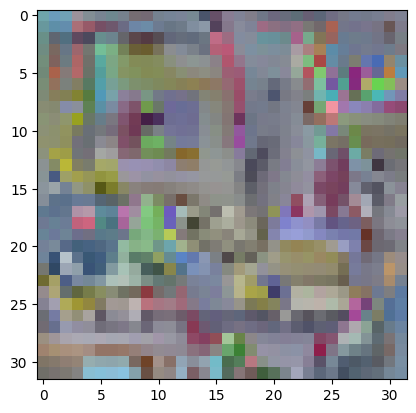

401 [-9493.977]
402 [-9429.127]
403 [-9398.016]
404 [-9395.324]
405 [-9430.425]
406 [-9191.774]
407 [-9550.526]
408 [-9178.321]
409 [-9379.048]
410 [-9161.401]
411 [-9390.069]
412 [-9096.57]
413 [-9252.533]
414 [-9148.389]
415 [-9391.969]
416 [-9050.191]
417 [-9165.227]
418 [-9030.199]
419 [-9037.771]
420 [-9056.256]
421 [-8902.042]
422 [-9281.432]
423 [-9089.245]
424 [-8901.169]
425 [-8989.765]
426 [-8800.199]
427 [-8863.979]
428 [-8831.145]
429 [-8901.975]
430 [-8719.701]
431 [-8819.141]
432 [-8756.801]
433 [-9048.855]
434 [-8594.725]
435 [-8819.877]
436 [-8599.911]
437 [-8840.348]
438 [-8491.215]
439 [-8819.453]
440 [-8458.109]
441 [-8748.704]
442 [-8294.479]
443 [-8789.551]
444 [-8254.281]
445 [-8745.205]
446 [-8347.842]
447 [-8592.154]
448 [-8286.33]
449 [-8471.426]
450 [-8219.254]
451 [-8431.722]
452 [-8058.8984]
453 [-8491.127]
454 [-8068.789]
455 [-8440.8]
456 [-8096.8647]
457 [-8263.66]
458 [-8141.146]
459 [-8133.7485]
460 [-8042.2246]
461 [-8211.292]
462 [-7858.5137]
463 [-81

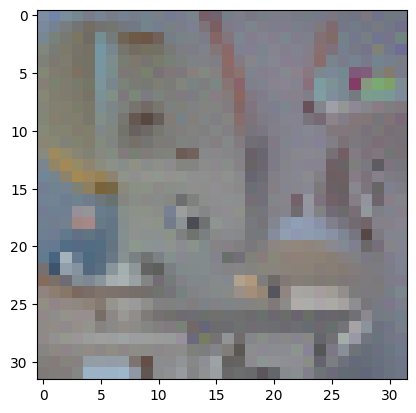

501 [-7360.4146]
502 [-7441.337]
503 [-7343.954]
504 [-7382.583]
505 [-7149.6543]
506 [-7540.45]
507 [-6969.9585]
508 [-7605.9443]
509 [-7009.5166]
510 [-7521.466]
511 [-7141.353]
512 [-7185.846]
513 [-7160.0903]
514 [-7254.8193]
515 [-7465.4307]
516 [-7184.74]
517 [-7283.299]
518 [-7038.259]
519 [-7215.3755]
520 [-7079.51]
521 [-7369.0664]
522 [-6833.109]
523 [-7402.221]
524 [-6741.905]
525 [-7446.632]
526 [-6644.8174]
527 [-7294.796]
528 [-6743.838]
529 [-8075.8594]
530 [-7090.4805]
531 [-7352.317]
532 [-6882.8237]
533 [-7095.8027]
534 [-6737.241]
535 [-7090.3535]
536 [-6751.357]
537 [-7230.5938]
538 [-6898.0776]
539 [-7011.131]
540 [-7337.9033]
541 [-6677.6304]
542 [-7167.0605]
543 [-6691.6465]
544 [-7076.7646]
545 [-6702.5386]
546 [-7158.4756]
547 [-6603.098]
548 [-7184.9756]
549 [-6494.2285]
550 [-7206.2197]
551 [-6453.875]
552 [-7581.677]
553 [-6669.9727]
554 [-7272.5073]
555 [-6787.8516]
556 [-7072.176]
557 [-6854.0957]
558 [-6926.463]
559 [-6930.6523]
560 [-6759.706]
561 [-7002

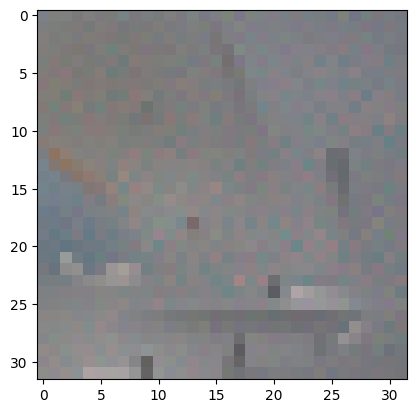

601 [-6958.7544]
602 [-7213.4316]
603 [-7294.8364]
604 [-7087.973]
605 [-7226.787]
606 [-6981.5933]
607 [-7226.911]
608 [-6962.867]
609 [-7393.6846]
610 [-7033.2476]
611 [-7132.711]
612 [-7247.9746]
613 [-7077.731]
614 [-7149.654]
615 [-7199.625]
616 [-6993.623]
617 [-7403.177]
618 [-7070.323]
619 [-7395.1943]
620 [-7033.072]
621 [-7274.8877]
622 [-7188.507]
623 [-7154.0845]
624 [-7233.4824]
625 [-7330.302]
626 [-7178.5474]
627 [-7180.9653]
628 [-7279.753]
629 [-7299.3003]
630 [-7365.2676]
631 [-7240.494]
632 [-7319.76]
633 [-7257.1875]
634 [-7267.122]
635 [-7489.429]
636 [-7305.752]
637 [-7260.9863]
638 [-7325.87]
639 [-7389.019]
640 [-7321.916]
641 [-7279.6367]
642 [-7382.0986]
643 [-7221.8467]
644 [-7251.812]
645 [-7419.3003]
646 [-7159.1084]
647 [-7338.3545]
648 [-7270.6016]
649 [-7274.8726]
650 [-7183.5947]
651 [-7282.759]
652 [-7214.4746]
653 [-7264.492]
654 [-7075.61]
655 [-7293.6895]
656 [-7284.3228]
657 [-7416.577]
658 [-7294.0938]
659 [-7290.4346]
660 [-7167.845]
661 [-7393.3

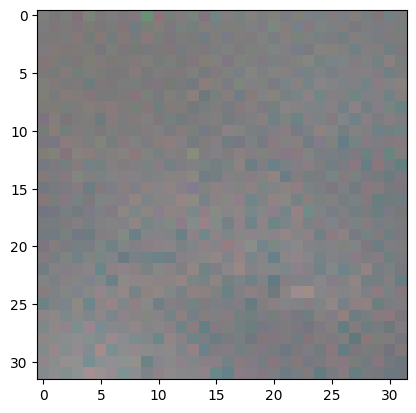

701 [-7287.589]
702 [-7409.5938]
703 [-7291.1133]
704 [-7482.1143]
705 [-7285.0645]
706 [-7344.453]
707 [-7213.902]
708 [-7251.7]
709 [-7320.9126]
710 [-7324.954]
711 [-7232.5225]
712 [-7309.0713]
713 [-7290.856]
714 [-7169.0405]
715 [-7538.902]
716 [-7213.798]
717 [-7246.8276]
718 [-7201.162]
719 [-7178.618]
720 [-7294.031]
721 [-7290.608]
722 [-7140.241]
723 [-7437.7246]
724 [-7285.0107]
725 [-7372.729]
726 [-7378.5703]
727 [-7276.371]
728 [-7399.0576]
729 [-7324.901]
730 [-7231.1963]
731 [-7357.1904]
732 [-7248.1113]
733 [-7182.964]
734 [-7292.4795]
735 [-7223.6436]
736 [-7465.5566]
737 [-7271.875]
738 [-7410.6484]
739 [-7225.278]
740 [-7290.4023]
741 [-7171.7656]
742 [-7277.394]
743 [-7317.6504]
744 [-7079.2285]
745 [-7404.636]
746 [-7157.9346]
747 [-7196.8633]
748 [-7156.616]
749 [-7304.8]
750 [-7278.1914]
751 [-7293.521]
752 [-7374.743]
753 [-7558.1113]
754 [-7343.4106]
755 [-7434.518]
756 [-7338.3545]
757 [-7181.4385]
758 [-7478.466]
759 [-7125.2046]
760 [-7780.1924]
761 [-7138.

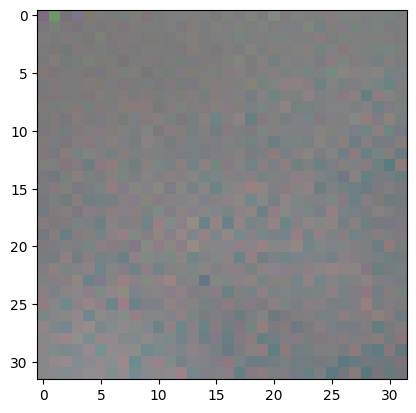

801 [-7204.64]
802 [-7251.46]
803 [-7098.718]
804 [-7486.11]
805 [-7234.951]
806 [-7537.292]
807 [-7202.871]
808 [-7369.833]
809 [-7159.3765]
810 [-7458.416]
811 [-7169.829]
812 [-7370.1387]
813 [-7294.052]
814 [-7414.577]
815 [-7116.8506]
816 [-7193.769]
817 [-7496.261]
818 [-7070.0386]
819 [-7592.6597]
820 [-7167.765]
821 [-7517.542]
822 [-7279.578]
823 [-7572.004]
824 [-7423.632]
825 [-7487.672]
826 [-7523.984]
827 [-7303.17]
828 [-7556.5713]
829 [-7380.0513]
830 [-7366.2773]
831 [-7254.282]
832 [-7443.7275]
833 [-7329.6094]
834 [-7535.0137]
835 [-7294.4814]
836 [-7288.398]
837 [-7261.583]
838 [-7283.8784]
839 [-7258.1777]
840 [-7355.2896]
841 [-7226.2246]
842 [-7396.287]
843 [-7100.952]
844 [-7430.483]
845 [-7264.7754]
846 [-7310.708]
847 [-7438.972]
848 [-7234.8545]
849 [-7454.9443]
850 [-7282.71]
851 [-7375.7153]
852 [-7369.8506]
853 [-7297.872]
854 [-7250.9556]
855 [-7179.6035]
856 [-7444.256]
857 [-7229.376]
858 [-7395.328]
859 [-7214.1006]
860 [-7269.9565]
861 [-7298.366]
862 

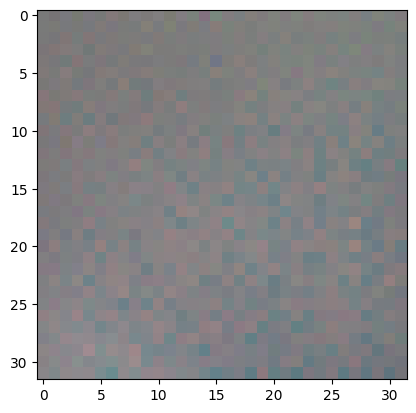

901 [-7614.7373]
902 [-7136.781]
903 [-7350.2197]
904 [-7283.166]
905 [-7416.252]
906 [-7182.177]
907 [-7365.1772]
908 [-7339.093]
909 [-7295.3965]
910 [-7245.541]
911 [-7430.213]
912 [-7374.169]
913 [-7312.5557]
914 [-7324.496]
915 [-7320.7734]
916 [-7434.8315]
917 [-7216.747]
918 [-7553.9985]
919 [-7226.2793]
920 [-7337.1494]
921 [-7138.758]
922 [-7367.1797]
923 [-7283.5356]
924 [-7514.9277]
925 [-7292.7783]
926 [-7574.21]
927 [-7204.3384]
928 [-7574.8755]
929 [-7316.633]
930 [-7374.983]
931 [-7404.487]
932 [-7191.9146]
933 [-7446.026]
934 [-7375.8174]
935 [-7312.746]
936 [-7335.3594]
937 [-7282.527]
938 [-7354.758]
939 [-7638.3657]
940 [-7127.9297]
941 [-7470.4697]
942 [-7216.9775]
943 [-7552.239]
944 [-7310.539]
945 [-7290.603]
946 [-7355.725]
947 [-7489.504]
948 [-7400.282]
949 [-7457.0312]
950 [-7248.7217]
951 [-7518.0015]
952 [-7367.352]
953 [-7291.482]
954 [-7219.916]
955 [-7525.25]
956 [-7425.045]
957 [-7332.4243]
958 [-7433.663]
959 [-7230.658]
960 [-7500.796]
961 [-7151.0234

In [24]:
# SUBIMOS LA PROBABILIDAD EN BUCLE
#SIGS = np.logspace(-10,0,500)

salto = 0.0001 # 0.000001

Nsteps = 1000
#RR = np.zeros(SIGS.shape)
pS = np.zeros(Nsteps)

X_limpiada = x_np_noise.copy()
GG_limpiada = prob_grad(torch.tensor(np.float32(X_limpiada), requires_grad=True))

for n in range(0,Nsteps):

    X_limpiada = X_limpiada + salto*GG_limpiada[1][0]
    GG_limpiada = prob_grad(torch.tensor(np.float32(X_limpiada), requires_grad=True))
#    RR[n] = np.sqrt(np.mean(sig*noise)**2)

    pS[n] = GG_limpiada[0]
    print(n,GG_limpiada[0])
    if n%100 == 0:
        plt.imshow(np.transpose(X_limpiada[0],(1,2,0)))
        plt.show()

# Metiendo un poquito de ruido en cada paso

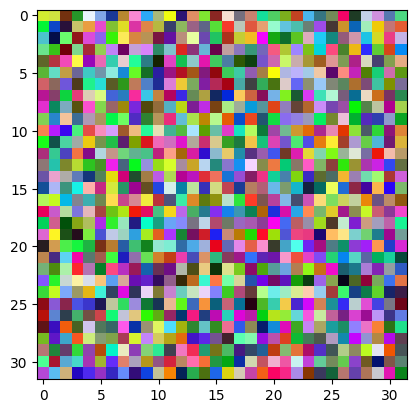

In [25]:
# CALCULAMOS EL GRADIENTE DE LA PROBABILIDAD DEL RUIDO

x_np_noise = 0.01*x_np+1*np.random.rand(3,32,32) # *
plt.imshow(np.transpose(x_np_noise[0],(1,2,0)))


<ipython-input-4-e5217d2c3bfe>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, requires_grad=True)
<ipython-input-26-5b670c837f4f>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pS[n] = GG_limpiada[0]


0 [-16807.656]


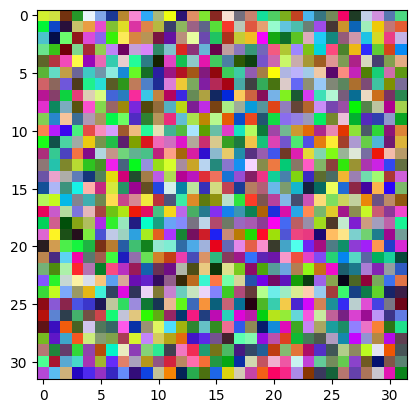

1 [-16791.912]
2 [-16767.957]
3 [-16747.514]
4 [-16726.701]
5 [-16698.89]
6 [-16670.771]
7 [-16653.766]
8 [-16629.383]
9 [-16612.004]
10 [-16587.227]
11 [-16563.064]
12 [-16540.6]
13 [-16518.516]
14 [-16496.766]
15 [-16479.033]
16 [-16458.09]
17 [-16437.334]
18 [-16416.996]
19 [-16396.422]
20 [-16376.481]
21 [-16359.524]
22 [-16337.192]
23 [-16320.503]
24 [-16301.557]
25 [-16275.998]
26 [-16264.233]
27 [-16245.852]
28 [-16224.55]
29 [-16203.76]
30 [-16188.299]
31 [-16170.42]
32 [-16152.874]
33 [-16138.553]
34 [-16121.404]
35 [-16104.348]
36 [-16087.473]
37 [-16070.864]
38 [-16054.451]
39 [-16038.217]
40 [-16022.113]
41 [-16006.117]
42 [-15990.3]
43 [-15974.579]
44 [-15958.984]
45 [-15943.502]
46 [-15928.11]
47 [-15915.814]
48 [-15900.561]
49 [-15885.376]
50 [-15870.253]
51 [-15855.139]
52 [-15840.078]
53 [-15825.134]
54 [-15810.276]
55 [-15791.951]
56 [-15777.18]
57 [-15762.506]
58 [-15747.972]
59 [-15733.541]
60 [-15719.221]
61 [-15704.97]
62 [-15693.862]
63 [-15679.762]
64 [-15665.70

100 [-15192.349]


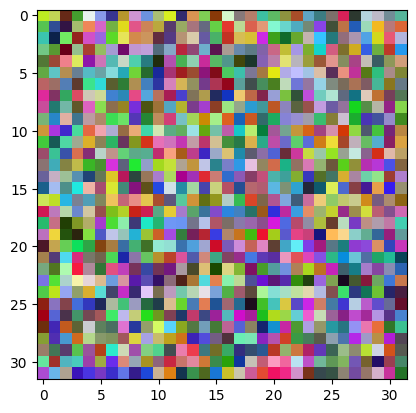

101 [-15179.575]
102 [-15167.436]
103 [-15154.504]
104 [-15142.02]
105 [-15129.6045]
106 [-15117.381]
107 [-15104.877]
108 [-15092.496]
109 [-15080.272]
110 [-15067.607]
111 [-15055.554]
112 [-15043.043]
113 [-15031.172]
114 [-15018.374]
115 [-15006.225]
116 [-14994.369]
117 [-14981.556]
118 [-14969.375]
119 [-14957.475]
120 [-14944.604]
121 [-14932.308]
122 [-14920.331]
123 [-14907.449]
124 [-14895.135]
125 [-14883.096]
126 [-14870.372]
127 [-14855.414]
128 [-14843.047]
129 [-14830.674]
130 [-14818.301]
131 [-14806.037]
132 [-14793.495]
133 [-14781.282]
134 [-14768.557]
135 [-14752.453]
136 [-14740.038]
137 [-14727.805]
138 [-14711.928]
139 [-14699.52]
140 [-14687.084]
141 [-14674.818]
142 [-14662.129]
143 [-14649.699]
144 [-14637.217]
145 [-14624.901]
146 [-14612.212]
147 [-14599.749]
148 [-14587.162]
149 [-14574.696]
150 [-14561.941]
151 [-14549.355]
152 [-14536.609]
153 [-14523.976]
154 [-14511.157]
155 [-14498.462]
156 [-14485.623]
157 [-14472.896]
158 [-14460.016]
159 [-14447.225

200 [-13885.16]


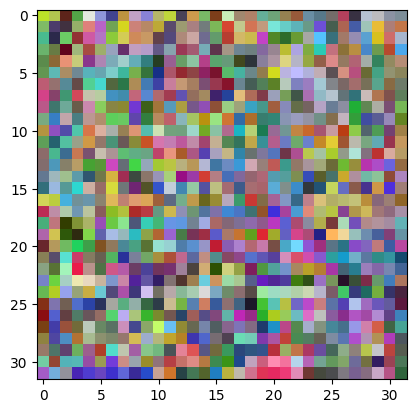

201 [-13870.169]
202 [-13855.266]
203 [-13839.826]
204 [-13824.578]
205 [-13808.867]
206 [-13793.516]
207 [-13777.689]
208 [-13762.209]
209 [-13746.246]
210 [-13730.505]
211 [-13716.967]
212 [-13700.863]
213 [-13684.639]
214 [-13668.406]
215 [-13652.062]
216 [-13635.688]
217 [-13619.197]
218 [-13602.631]
219 [-13585.729]
220 [-13568.611]
221 [-13551.533]
222 [-13537.295]
223 [-13519.851]
224 [-13502.178]
225 [-13484.361]
226 [-13466.422]
227 [-13448.26]
228 [-13430.197]
229 [-13413.053]
230 [-13393.735]
231 [-13375.856]
232 [-13355.852]
233 [-13336.453]
234 [-13318.428]
235 [-13299.891]
236 [-13278.047]
237 [-13258.02]
238 [-13237.883]
239 [-13220.121]
240 [-13197.208]
241 [-13175.105]
242 [-13155.734]
243 [-13136.005]
244 [-13111.879]
245 [-13088.506]
246 [-13066.726]
247 [-13046.393]
248 [-13026.535]
249 [-13001.107]
250 [-12981.387]
251 [-12958.752]
252 [-12937.799]
253 [-12910.777]
254 [-12883.951]
255 [-12862.264]
256 [-12842.984]
257 [-12817.285]
258 [-12797.9375]
259 [-12773.372

300 [-11658.204]


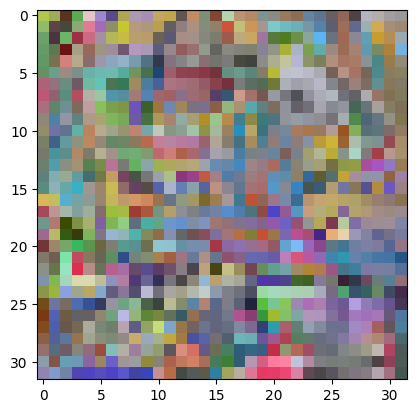

301 [-11682.092]
302 [-11586.948]
303 [-11584.73]
304 [-11534.773]
305 [-11499.336]
306 [-11476.715]
307 [-11424.322]
308 [-11418.701]
309 [-11343.1875]
310 [-11348.596]
311 [-11283.848]
312 [-11271.201]
313 [-11241.076]
314 [-11236.338]
315 [-11165.846]
316 [-11136.965]
317 [-11137.506]
318 [-11082.531]
319 [-11045.809]
320 [-10995.605]
321 [-10999.372]
322 [-10912.682]
323 [-10890.1]
324 [-10898.698]
325 [-10834.611]
326 [-10779.43]
327 [-10785.262]
328 [-10731.084]
329 [-10696.706]
330 [-10623.384]
331 [-10680.697]
332 [-10604.155]
333 [-10555.869]
334 [-10521.799]
335 [-10514.84]
336 [-10420.898]
337 [-10437.423]
338 [-10383.717]
339 [-10326.543]
340 [-10354.892]
341 [-10307.594]
342 [-10283.045]
343 [-10212.185]
344 [-10228.6]
345 [-10193.235]
346 [-10055.184]
347 [-10121.379]
348 [-10059.471]
349 [-10029.193]
350 [-10058.063]
351 [-9943.992]
352 [-9926.111]
353 [-9923.26]
354 [-9773.436]
355 [-9931.92]
356 [-9724.691]
357 [-9836.12]
358 [-9708.41]
359 [-9762.945]
360 [-9656.538]


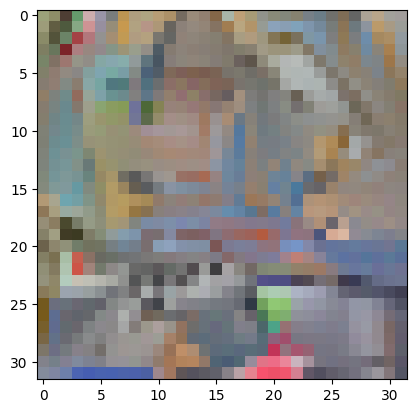

401 [-8794.1455]
402 [-8396.781]
403 [-8889.576]
404 [-8271.0625]
405 [-8634.627]
406 [-8369.652]
407 [-8610.925]
408 [-8293.389]
409 [-8671.309]
410 [-8171.921]
411 [-8568.041]
412 [-8268.105]
413 [-8368.927]
414 [-8437.814]
415 [-8373.025]
416 [-8242.455]
417 [-8545.156]
418 [-8118.0264]
419 [-8362.801]
420 [-8217.442]
421 [-8200.061]
422 [-8171.4346]
423 [-8189.1675]
424 [-8156.18]
425 [-8166.662]
426 [-8062.7666]
427 [-8199.241]
428 [-7986.282]
429 [-8036.285]
430 [-8050.672]
431 [-8036.2456]
432 [-8179.61]
433 [-7743.9175]
434 [-8136.9287]
435 [-7848.961]
436 [-8117.5967]
437 [-8044.7617]
438 [-7825.419]
439 [-8044.821]
440 [-7767.6743]
441 [-7979.666]
442 [-7853.1714]
443 [-7889.883]
444 [-7772.0366]
445 [-7699.007]
446 [-7922.573]
447 [-7685.0083]
448 [-7858.915]
449 [-7599.633]
450 [-7893.9062]
451 [-7629.1963]
452 [-7741.901]
453 [-7557.7812]
454 [-7807.8535]
455 [-7570.366]
456 [-7685.672]
457 [-7777.1104]
458 [-7344.623]
459 [-7870.651]
460 [-7371.9844]
461 [-7806.6523]
462 

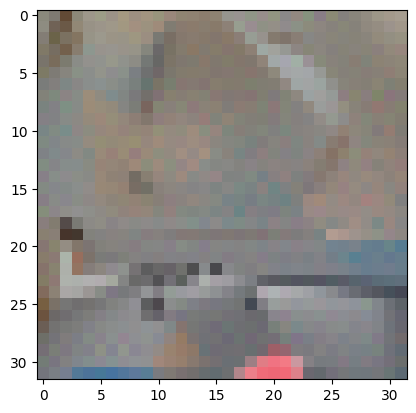

501 [-6794.244]
502 [-7624.9443]
503 [-6913.12]
504 [-7419.331]
505 [-6843.0806]
506 [-7347.7515]
507 [-7006.268]
508 [-7247.026]
509 [-7067.6816]
510 [-7069.1177]
511 [-7126.5225]
512 [-7141.7754]
513 [-7058.772]
514 [-7196.416]
515 [-6938.703]
516 [-7228.1914]
517 [-6893.4365]
518 [-7197.727]
519 [-7078.628]
520 [-7103.782]
521 [-6922.8296]
522 [-7158.198]
523 [-6737.9844]
524 [-7268.4043]
525 [-7031.349]
526 [-7172.904]
527 [-7103.2275]
528 [-7102.8857]
529 [-6897.3228]
530 [-7073.3438]
531 [-6892.0796]
532 [-7254.534]
533 [-6830.9243]
534 [-6952.8]
535 [-6926.0254]
536 [-6930.505]
537 [-7196.344]
538 [-6967.2207]
539 [-6996.179]
540 [-6923.7524]
541 [-7018.915]
542 [-6851.7373]
543 [-7161.16]
544 [-6730.2754]
545 [-7050.6973]
546 [-6736.635]
547 [-7076.3296]
548 [-6779.841]
549 [-7195.3853]
550 [-6746.21]
551 [-7092.5986]
552 [-6882.609]
553 [-7078.24]
554 [-6950.732]
555 [-7140.5234]
556 [-6862.4043]
557 [-7281.3965]
558 [-6870.3433]
559 [-7291.3477]
560 [-6649.1714]
561 [-7320.62

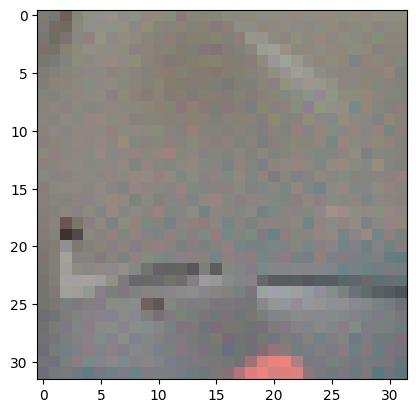

601 [-6601.3604]
602 [-7271.463]
603 [-6771.6934]
604 [-7239.1562]
605 [-6814.6523]
606 [-7054.7896]
607 [-6896.0723]
608 [-7525.4746]
609 [-7016.305]
610 [-7151.296]
611 [-6958.96]
612 [-7181.8833]
613 [-6905.884]
614 [-7107.495]
615 [-6967.4653]
616 [-7120.]
617 [-6882.6963]
618 [-7095.234]
619 [-6988.8984]
620 [-6912.6655]
621 [-7228.25]
622 [-6999.2305]
623 [-7066.717]
624 [-7172.7354]
625 [-7010.493]
626 [-7065.859]
627 [-7039.8545]
628 [-7056.3545]
629 [-7053.09]
630 [-7059.6445]
631 [-7263.414]
632 [-6863.879]
633 [-7410.879]
634 [-6822.6797]
635 [-7294.9854]
636 [-7008.937]
637 [-7270.169]
638 [-6975.471]
639 [-7096.337]
640 [-7110.049]
641 [-7064.285]
642 [-6948.313]
643 [-7127.297]
644 [-6933.542]
645 [-7238.143]
646 [-6902.632]
647 [-7196.284]
648 [-7031.748]
649 [-7021.386]
650 [-6972.844]
651 [-7092.191]
652 [-7018.7725]
653 [-7028.629]
654 [-7002.09]
655 [-7236.369]
656 [-7046.0117]
657 [-7084.4756]
658 [-7062.4683]
659 [-7150.7217]
660 [-6986.6064]
661 [-7115.0757]
662 [

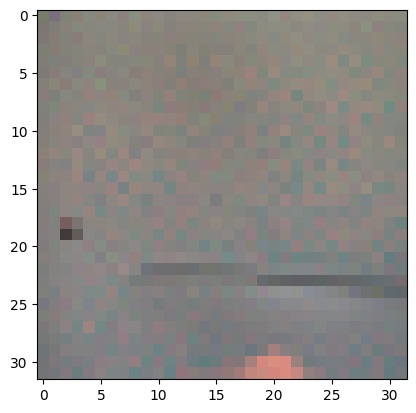

701 [-7208.9644]
702 [-6963.5903]
703 [-7182.4487]
704 [-7147.924]
705 [-7182.8013]
706 [-7181.227]
707 [-7159.621]
708 [-7333.283]
709 [-7113.4277]
710 [-7360.9316]
711 [-7019.109]
712 [-7335.045]
713 [-7075.763]
714 [-7040.0312]
715 [-7160.9062]
716 [-7079.144]
717 [-7335.2495]
718 [-7110.3267]
719 [-7128.785]
720 [-7349.331]
721 [-7230.828]
722 [-7185.7285]
723 [-7244.527]
724 [-7116.9136]
725 [-7191.372]
726 [-7141.666]
727 [-7230.046]
728 [-7199.384]
729 [-7250.106]
730 [-7154.0615]
731 [-7387.522]
732 [-7083.4106]
733 [-7244.993]
734 [-7039.947]
735 [-7123.2275]
736 [-7240.6123]
737 [-7072.291]
738 [-7616.9316]
739 [-7395.301]
740 [-7307.59]
741 [-7247.49]
742 [-7183.1133]
743 [-7161.4297]
744 [-7152.3125]
745 [-7132.642]
746 [-7206.2915]
747 [-7170.1787]
748 [-7082.616]
749 [-7119.0938]
750 [-7186.3066]
751 [-7156.0127]
752 [-7080.067]
753 [-7062.47]
754 [-7110.3037]
755 [-7173.465]
756 [-7252.504]
757 [-7193.698]
758 [-7214.997]
759 [-7303.6387]
760 [-7141.995]
761 [-7138.1846]

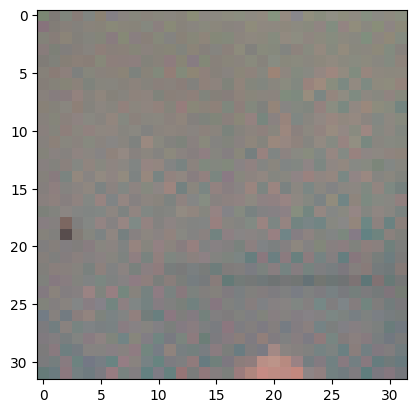

801 [-7223.1104]
802 [-7200.073]
803 [-7081.019]
804 [-7309.132]
805 [-7089.5537]
806 [-7096.1973]
807 [-7246.247]
808 [-7114.3423]
809 [-7277.198]
810 [-7049.462]
811 [-7255.032]
812 [-7035.634]
813 [-7082.5405]
814 [-7167.3516]
815 [-7146.464]
816 [-7201.83]
817 [-7097.499]
818 [-7158.5127]
819 [-7164.692]
820 [-7092.4272]
821 [-7275.179]
822 [-7120.405]
823 [-7130.831]
824 [-7204.4434]
825 [-7099.7793]
826 [-7201.6055]
827 [-7033.4443]
828 [-7393.6216]
829 [-7159.22]
830 [-7197.188]
831 [-7247.7837]
832 [-7077.837]
833 [-7181.0244]
834 [-7187.6855]
835 [-7399.4307]
836 [-7057.134]
837 [-7315.9434]
838 [-7275.374]
839 [-7313.037]
840 [-7166.253]
841 [-7337.355]
842 [-7310.479]
843 [-7163.2393]
844 [-7600.423]
845 [-7087.469]
846 [-7293.3867]
847 [-7171.0146]


KeyboardInterrupt: 

In [26]:
# SUBIMOS LA PROBABILIDAD EN BUCLE
#SIGS = np.logspace(-10,0,500)

salto = 0.0001 # 0.000001

poquito_de_ruido = 0.1*salto

Nsteps = 3000
#RR = np.zeros(SIGS.shape)
pS = np.zeros(Nsteps)

X_limpiada = x_np_noise.copy()
GG_limpiada = prob_grad(torch.tensor(np.float32(X_limpiada), requires_grad=True))

for n in range(0,Nsteps):

    X_limpiada = X_limpiada + salto*GG_limpiada[1][0]
    GG_limpiada = prob_grad(torch.tensor(np.float32(X_limpiada), requires_grad=True))
#    RR[n] = np.sqrt(np.mean(sig*noise)**2)

    X_limpiada = X_limpiada + poquito_de_ruido*np.random.rand(3,32,32)
    pS[n] = GG_limpiada[0]
    print(n,GG_limpiada[0])
    if n%100 == 0:
        plt.imshow(np.transpose(X_limpiada[0],(1,2,0)))
        plt.show()

In [ ]:
# CALCULAMOS LA PROBABILIDAD
x_np_t = torch.tensor(np.float32(x_np), requires_grad=True)
log_prob(x_np_t)

tensor([-6154.8276], device='cuda:0', grad_fn=<SumBackward1>)

In [ ]:
# CALCULAMOS EL EFECTO DEL RUIDO EN LA PROBABILIDAD
SIGS = np.logspace(-10,0,500)

RR = np.zeros(SIGS.shape)
pS = np.zeros(SIGS.shape)

np.random.seed(0)
noise = np.random.randn(*x_np.shape)

for n in range(0,len(SIGS)):
    sig = SIGS[n]

    x_np_copy = x_np + sig*noise
    x = torch.tensor(np.float32(x_np_copy), requires_grad=True)

    RR[n] = np.sqrt(np.mean(sig*noise)**2)
    pS[n] = log_prob(x).detach().cpu().numpy()
    print(n)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
import matplotlib.pyplot as plt
font = {'size'   : 22}

plt.rc('font', **font)

Text(0.5, 0, 'noise level')

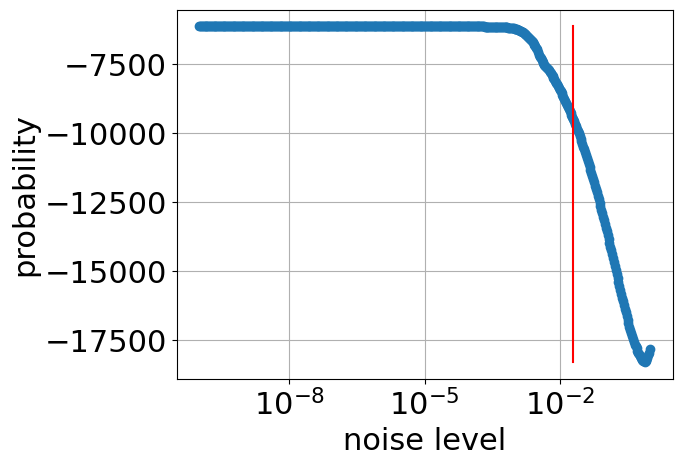

In [ ]:
plt.semilogx(SIGS,pS,'o-')
plt.grid()

plt.plot([0.02,0.02],[min(pS),max(pS)],'r')
plt.ylabel('probability')
plt.xlabel('noise level')

In [ ]:
# CALCULAMOS EL JACOBIANO
print(x_np.shape)

print(x.size())
output = log_prob(x)
J = torch.autograd.functional.jacobian(log_prob, x)
print(J.size())

(1, 3, 32, 32)
torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 3, 32, 32])


In [ ]:
J.shape

torch.Size([1, 1, 3, 32, 32])

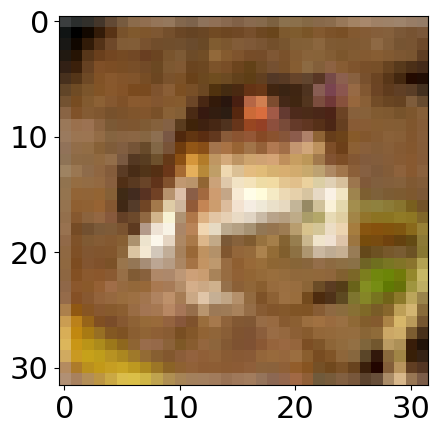

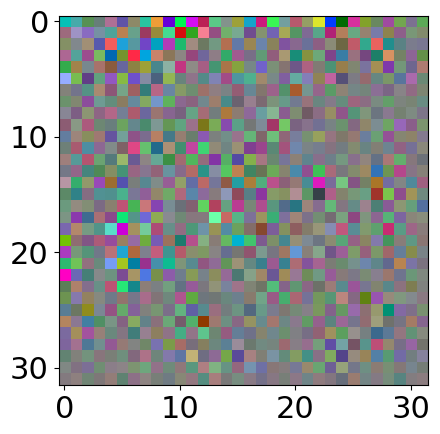

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(np.transpose(x_np[0], (1, 2, 0)))
plt.figure()
plt.imshow(np.transpose(J[0, 0], (1, 2, 0))/J[0, 0].max()+0.5)